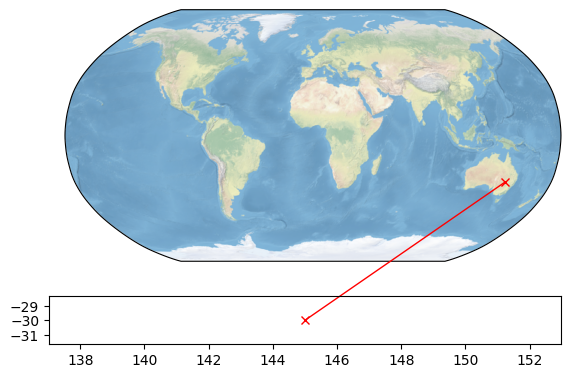

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs

plt.close('all')
fig = plt.figure()
ax = plt.subplot(projection=ccrs.Robinson())

lon,lat = 145,-30

ax.stock_img()
ax.plot(lon,lat, marker='x', color='r', transform=ccrs.PlateCarree())

ax2 = fig.add_axes([0.1,0.06,0.8,0.1])
ax2.plot(lon,lat,marker='x', color='r')

use_proj = ccrs.Robinson()
xyA = use_proj.transform_point(lon, lat, ccrs.PlateCarree())

# line between axes
con = patches.ConnectionPatch(
    xyA=xyA, 
    xyB=(lon,lat), 
    coordsA='data', coordsB='data', axesA=ax, axesB=ax2, color='r')
ax2.add_artist(con)

plt.show()

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------
def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate CSV file with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Save to CSV
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])
#df.to_csv(csv_output, index=False)
#print(f"CSV file '{csv_output}' created successfully.")

# Show the plot
#plt.show()
# Create subplot 1
#ax1 = fig.add_subplot(1, 2, 1)

#x1, y1 = 0.5, 0.5  # Example point in subplot 1

#ax1.plot(x1, y1, 'bx', label='Point 1')
#ax1.set_title('Subplot 1')
#ax1.set_xlim(0, 1)
#ax1.set_ylim(0, 1)
# ax1.legend()


# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------
gps = pd.read_csv(r'../data/sample_data_mada.csv', index_col=0)
gps.index.name = "ID"

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree()) # PROBLEM HERE
# Define the extent of the map (centered around Madagascar)
extent = [43, 51, -27, -11]
ax2.set_extent(extent)

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    ax2.plot(row["longitude"], row["latitude"], 'ro', markersize=1)

# Add coastlines and country borders for context
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)


ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(['Species'], loc='upper right')


# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Hard-code specific coordinates
# longitude, latitude = 47.5, -18.9  # Example coordinates
# longitude, latitude = 47.781762,-14.79531  # Example coordinates (L31, C_perrieri_A12,47.781762,-14.79531)



# ------------------------------------------
# ------------  Connection patch -----------
# ------------------------------------------
'''
#xyA = (0.5, 0.5)  # Point in the First subplot
xyA  = df.loc[30, 'Coordinates']
# xyB = (2, 2)  # Point in the Second subplot
xyB = (47.781762,-14.79531) # Point in the Second subplot
xyB1 = (49.39833,-12.388317) # Point in the Second subplot

# Create a ConnectionPatch (green)
con = ConnectionPatch(
    xyA=xyA, coordsA="data",
    xyB=xyB, coordsB="data",
    axesA=ax_tree, axesB=ax2,
    color="green", linewidth=1, linestyle="--",
    zorder=2
)

# Add the ConnectionPatch to the Cartesian subplot's axes
fig.add_artist(con)

#xyA = (0.5, 0.5)  # Point in the First subplot
# Create a ConnectionPatch (teal)
con = ConnectionPatch(
    xyA=xyA, coordsA="data",
    xyB=xyB1, coordsB="data",
    axesA=ax_tree, axesB=ax2,
    color="teal", linewidth=1, linestyle="--"
)

fig.add_artist(con)
'''

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding coordinates from gps DataFrame
    if row['ID'] in gps.index:
        species_coords = (gps.loc[row['ID'], 'longitude'], gps.loc[row['ID'], 'latitude'])
        # Create connection patch
        con = ConnectionPatch(
            xyA=row['Coordinates'], coordsA="data",
            xyB=species_coords, coordsB="data",
            axesA=ax_tree, axesB=ax2,
            color="green", linewidth=1, linestyle="--",
            zorder=2
        )
        fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()# Create a new map with PlateCarree projection

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 2600x1100 with 2 Axes>

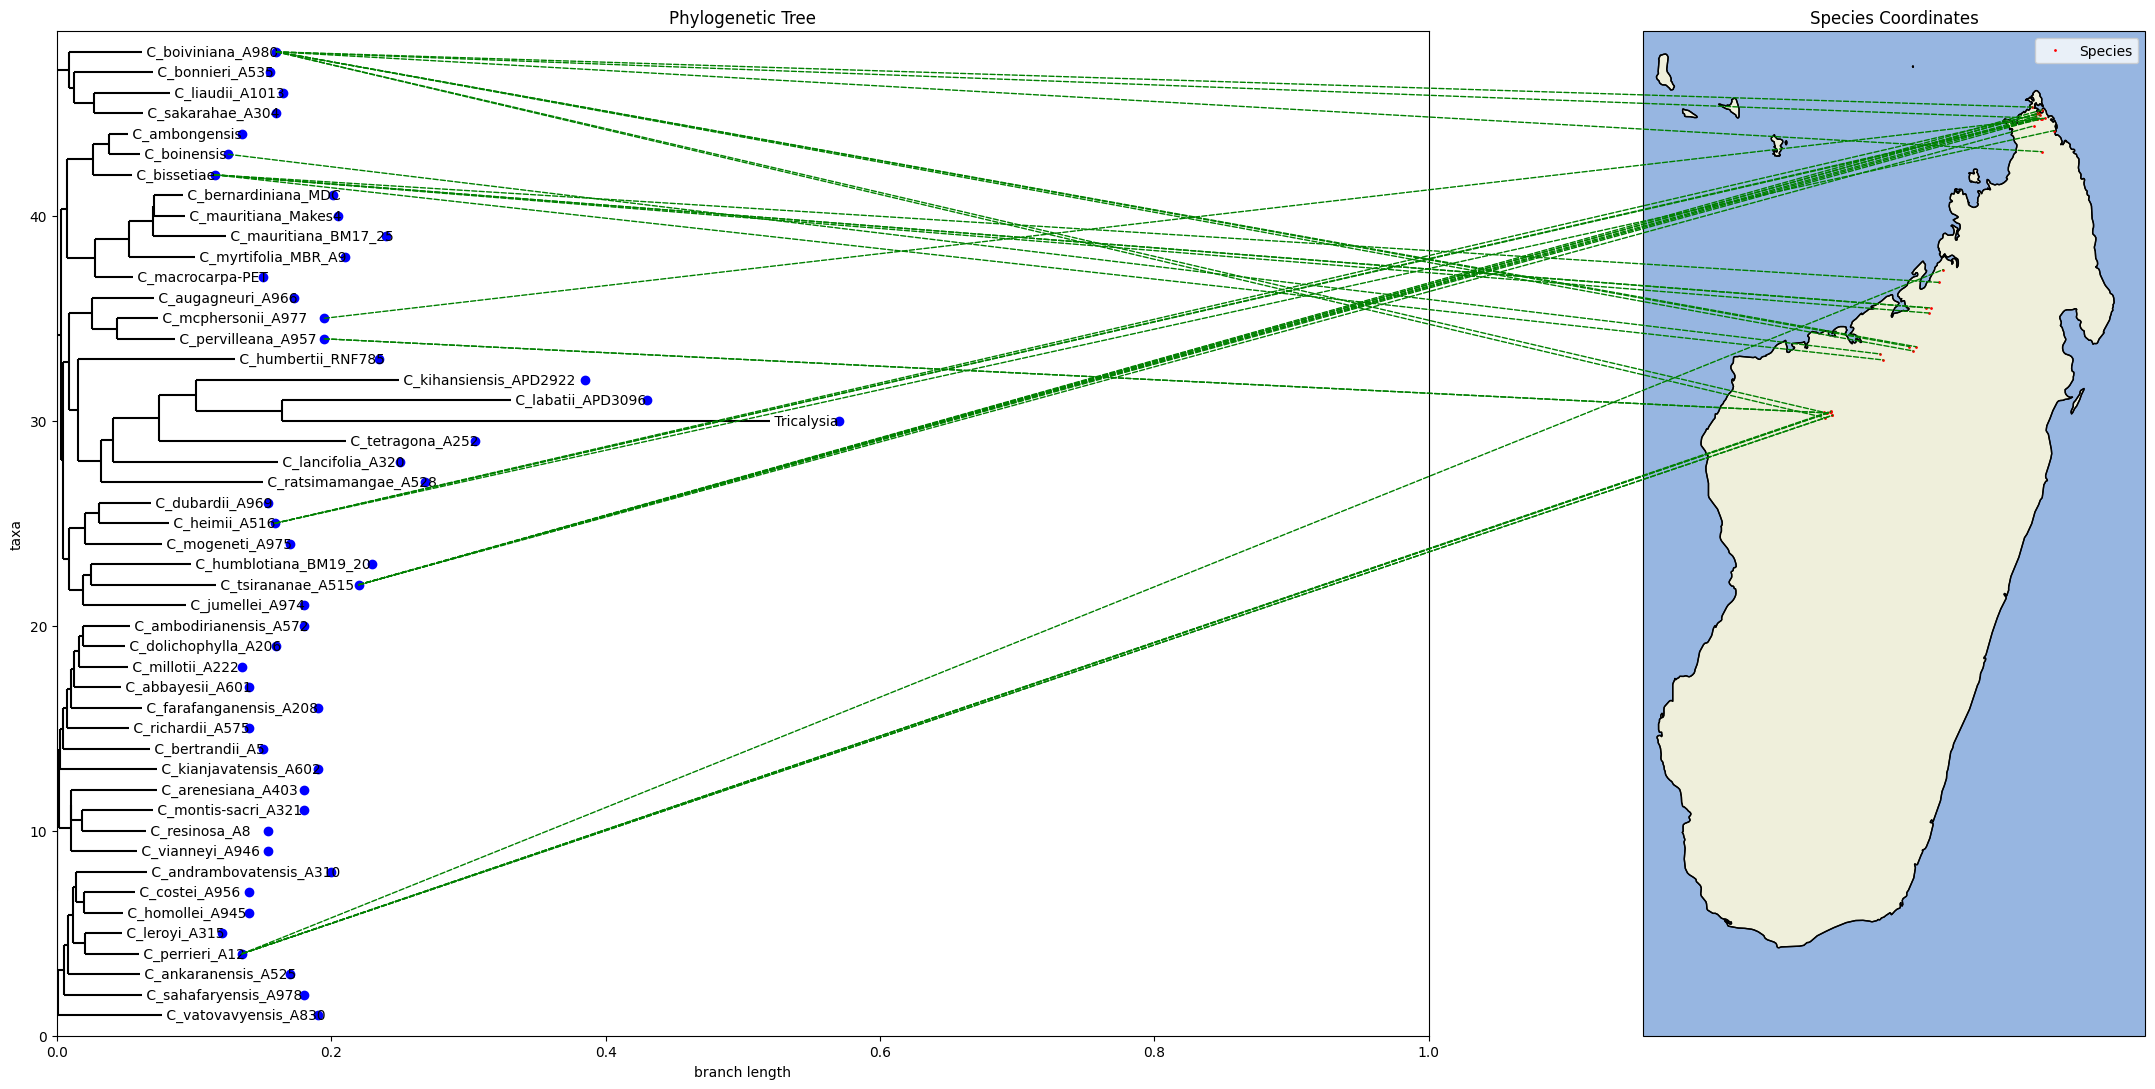

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
extent = [43, 51, -27, -11]
ax2.set_extent(extent)

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    ax2.plot(row["longitude"], row["latitude"], 'ro', markersize=1)

# Add coastlines and country borders for context
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(['Species'], loc='upper right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Group gps DataFrame by ID and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color="green", linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


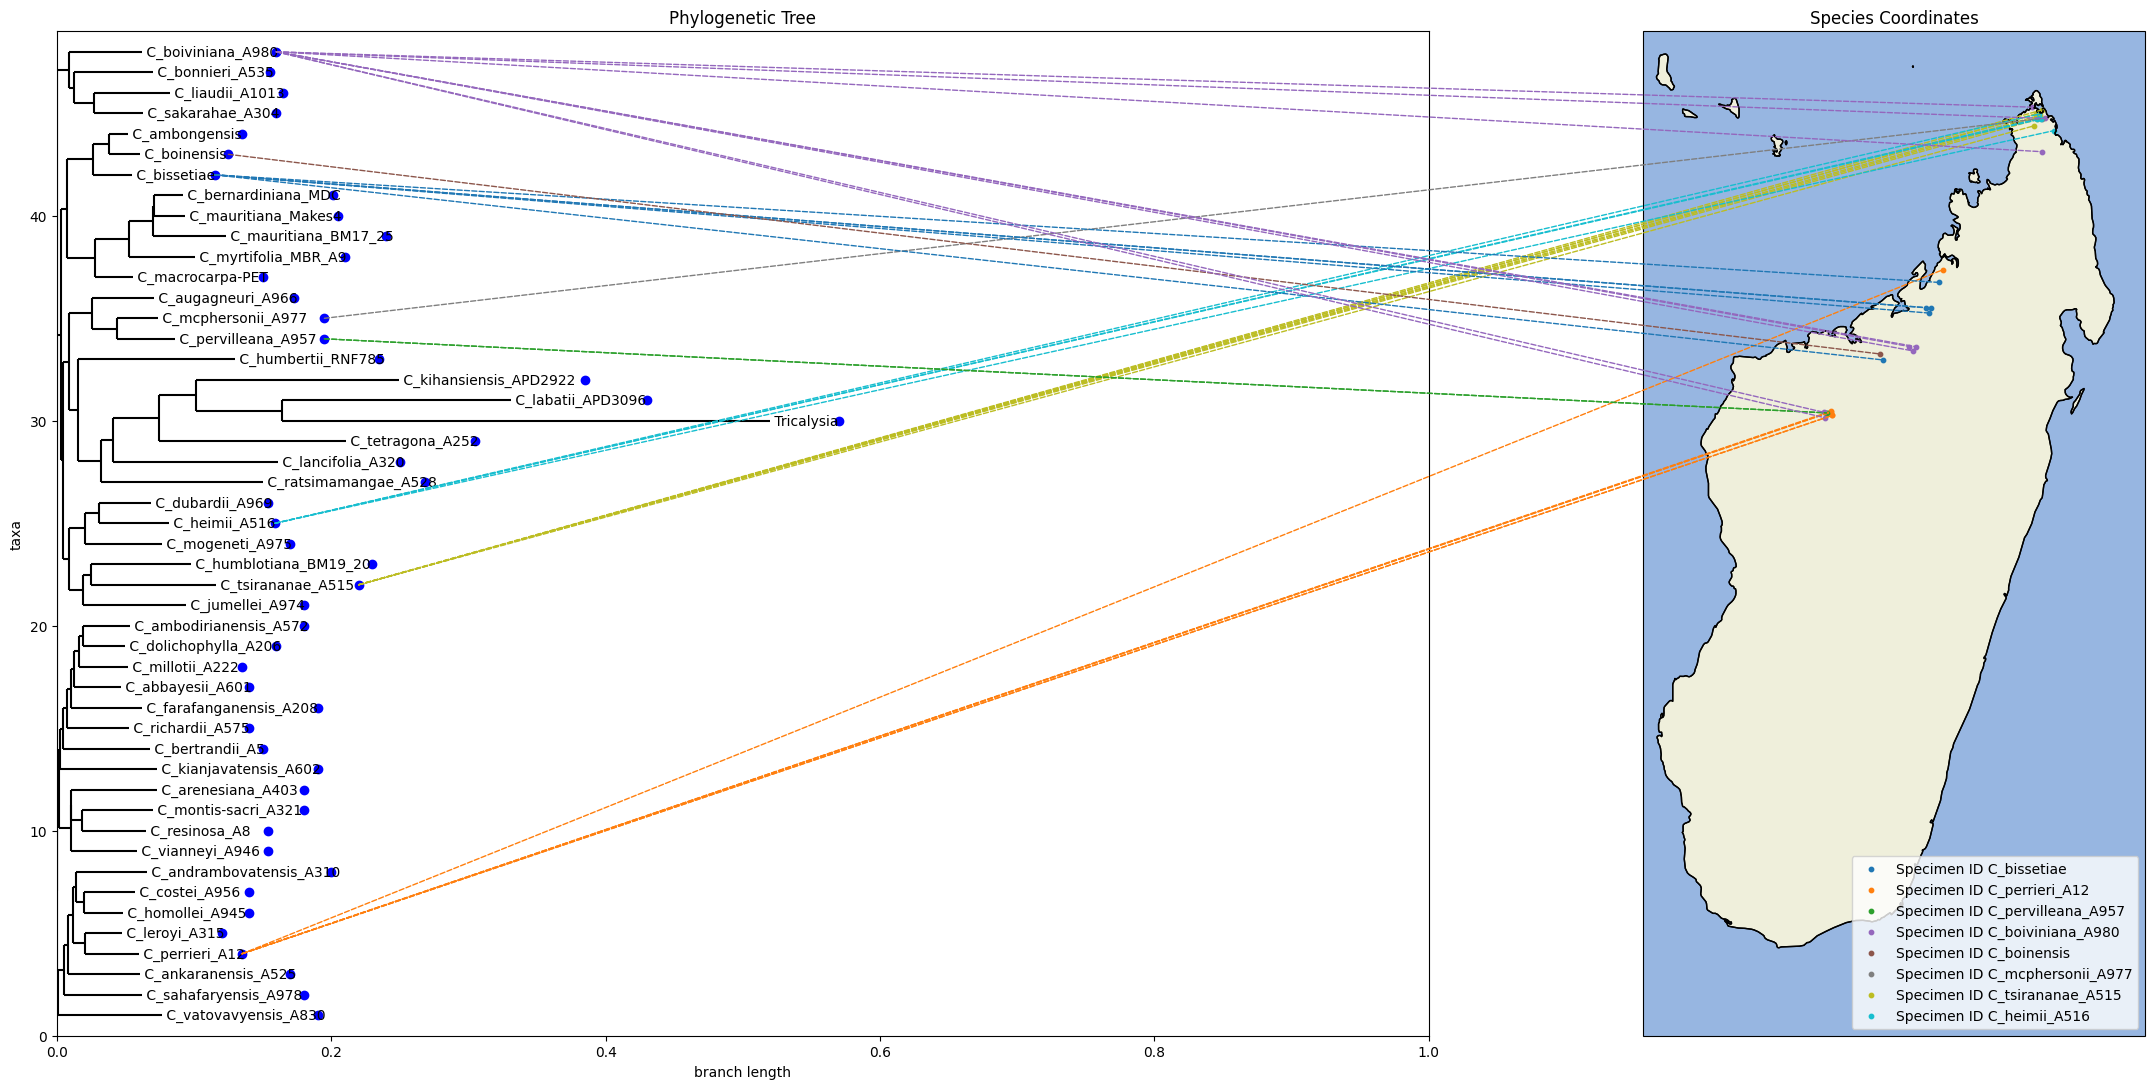

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo
import numpy as np

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Group gps DataFrame by specimen_id and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Generate unique colors for each specimen_id
unique_specimen_ids = gps['specimen_id'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_specimen_ids)))  # Generate colors from a colormap

specimen_id_color_map = {specimen_id: colors[i] for i, specimen_id in enumerate(unique_specimen_ids)}

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
extent = [43, 51, -27, -11]
ax2.set_extent(extent)

# Plot points from GPS dataframe on the map, using unique colors for each specimen_id
for specimen_id, color in specimen_id_color_map.items():
    if specimen_id in gps_grouped:
        coordinates = gps_grouped[specimen_id]
        lon, lat = zip(*coordinates)
        ax2.scatter(lon, lat, color=color, label=f"Specimen ID {specimen_id}", s=10)

# Add coastlines and country borders for context
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(loc='lower right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color=specimen_id_color_map[row['ID']], linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


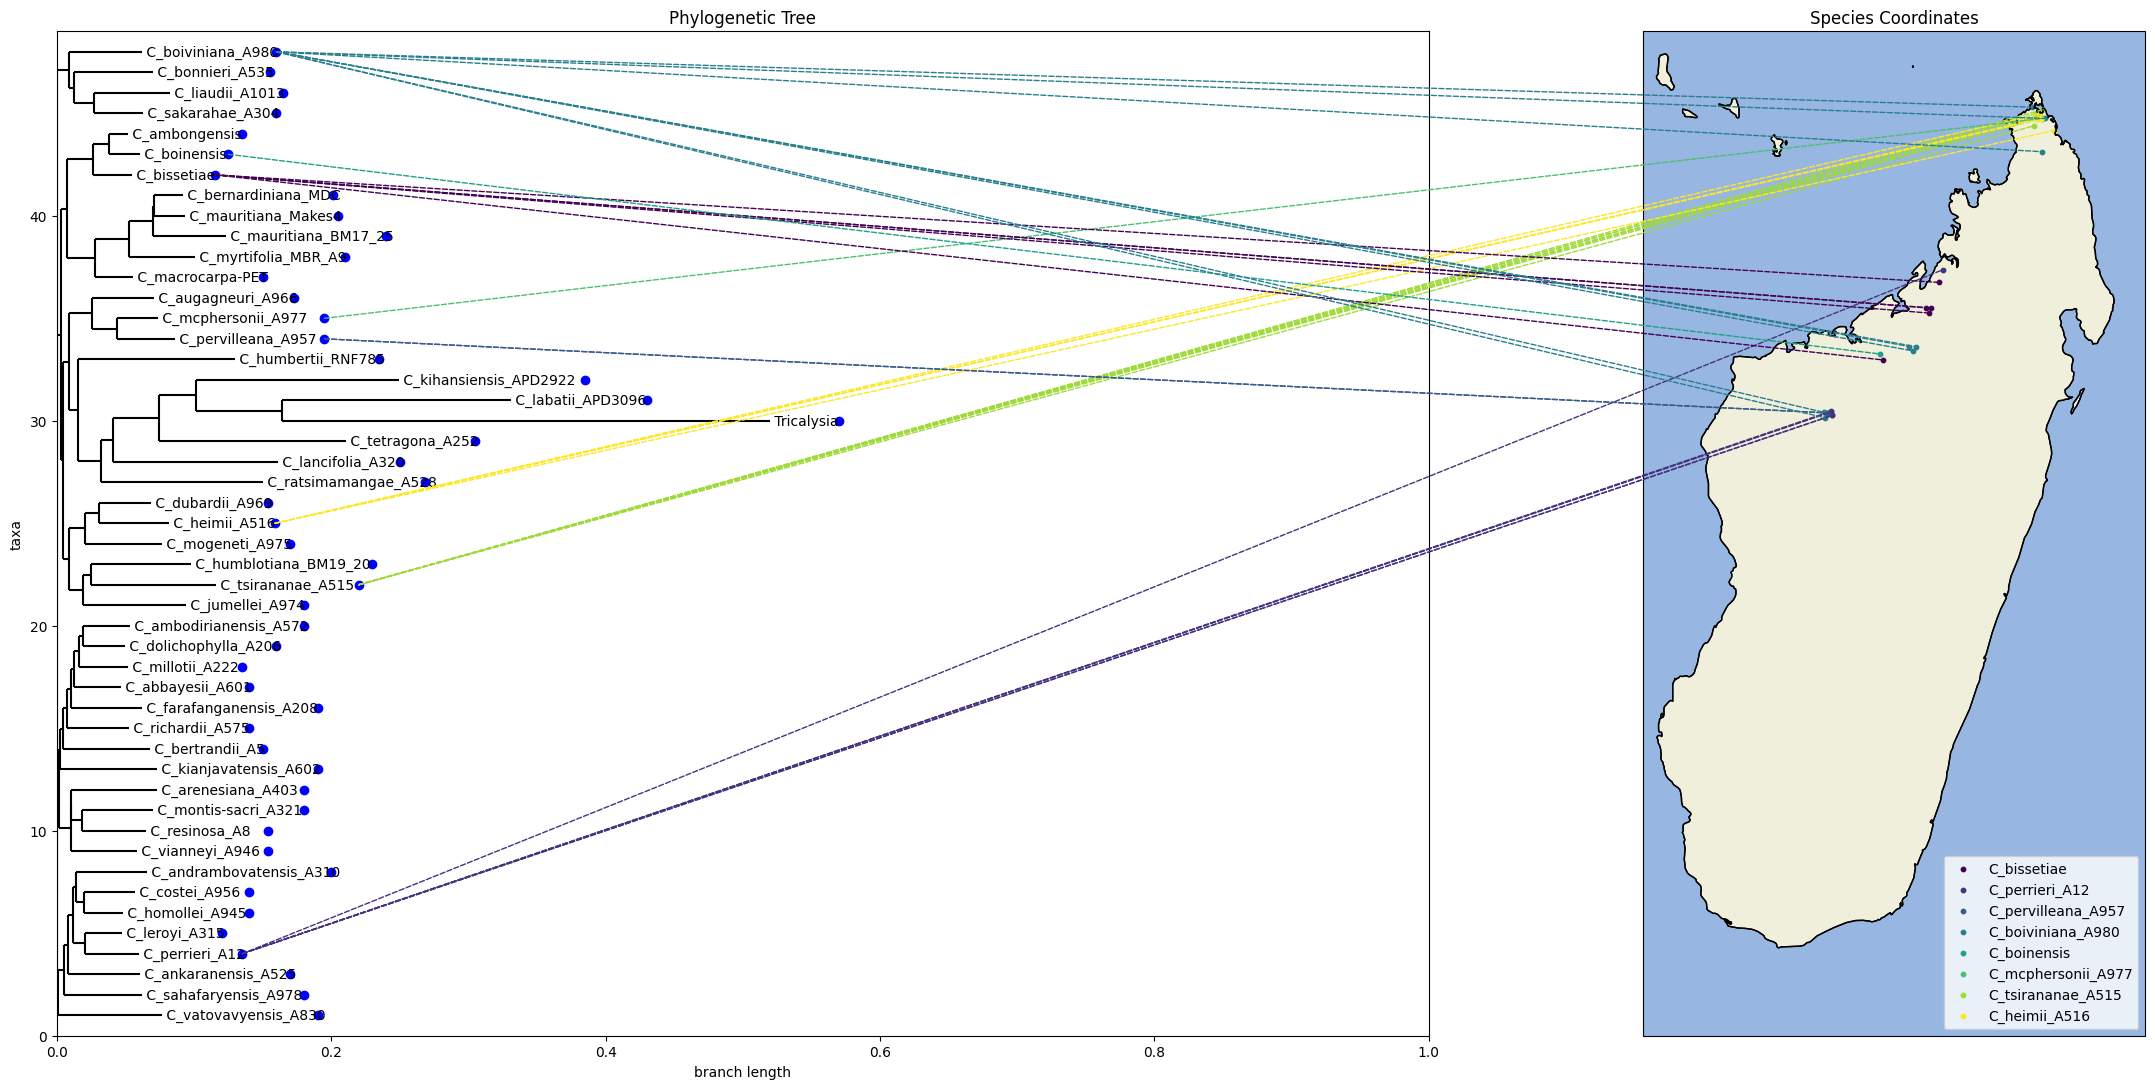

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo
import numpy as np

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Group gps DataFrame by specimen_id and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Generate colors using viridis colormap
unique_specimen_ids = gps['specimen_id'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_specimen_ids)))  # Generate colors from 'viridis' colormap

specimen_id_color_map = {specimen_id: colors[i] for i, specimen_id in enumerate(unique_specimen_ids)}

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
extent = [43, 51, -27, -11]
ax2.set_extent(extent)

# Plot points from GPS dataframe on the map, using unique colors for each specimen_id
scatter_handles = []
for specimen_id, color in specimen_id_color_map.items():
    if specimen_id in gps_grouped:
        coordinates = gps_grouped[specimen_id]
        lon, lat = zip(*coordinates)
        scatter = ax2.scatter(lon, lat, color=color, label=f"Specimen ID {specimen_id}", s=10)
        scatter_handles.append(scatter)

# Add coastlines and country borders for context
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)

#ax2.stock_img()
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")

# Customize legend
legend_labels = [f"{specimen_id}" for specimen_id in specimen_id_color_map.keys()]
ax2.legend(scatter_handles, legend_labels, loc='lower right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color=specimen_id_color_map[row['ID']], linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [11]:
import rasterio
from matplotlib import pyplot as plt

# Replace with your raster file path
raster_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_enviro.tif"

# Open the raster file
with rasterio.open(raster_file) as src:
    raster_data = src.read(8)  # Read the first band
    raster_extent = src.bounds  # Get the extent of the raster (xmin, ymin, xmax, ymax)
    raster_crs = src.crs       # Get the coordinate reference system (CRS) of the raster


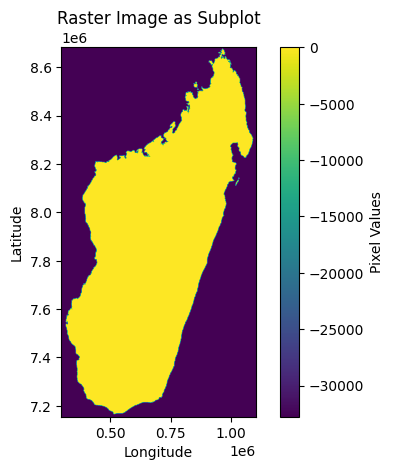

In [13]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the raster image
img_plot = ax.imshow(raster_data, extent=[raster_extent.left, raster_extent.right, raster_extent.bottom, raster_extent.top])

# Customize plot settings if needed (e.g., title, labels, etc.)
ax.set_title('Raster Image as Subplot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar for interpretation of pixel values
cbar = fig.colorbar(img_plot, ax=ax)
cbar.set_label('Pixel Values')

# Optionally, overlay additional data or markers using map coordinates
# For example, plot a point using map coordinates (assuming you have them)
#map_longitude = -18.0
#map_latitude = 48.0
#ax.plot(map_longitude, map_latitude, marker='o', color='red', markersize=10, label='Map Point')
#ax.legend()

# Display the plot
plt.show()


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo
import rasterio
from rasterio.plot import show

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"
tiff_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_enviro.tif"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
extent = [43, 51, -27, -11]
ax2.set_extent(extent)

# Plot the first layer of the TIFF as the background
with rasterio.open(tiff_file) as src:
    ax2.imshow(src.read(1), extent=extent, transform=ccrs.PlateCarree(), origin='upper')#, cmap='viridis')

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    ax2.plot(row["longitude"], row["latitude"], 'ro', markersize=1)

# Add coastlines and country borders for context
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(['Species'], loc='upper right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Group gps DataFrame by ID and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color="green", linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


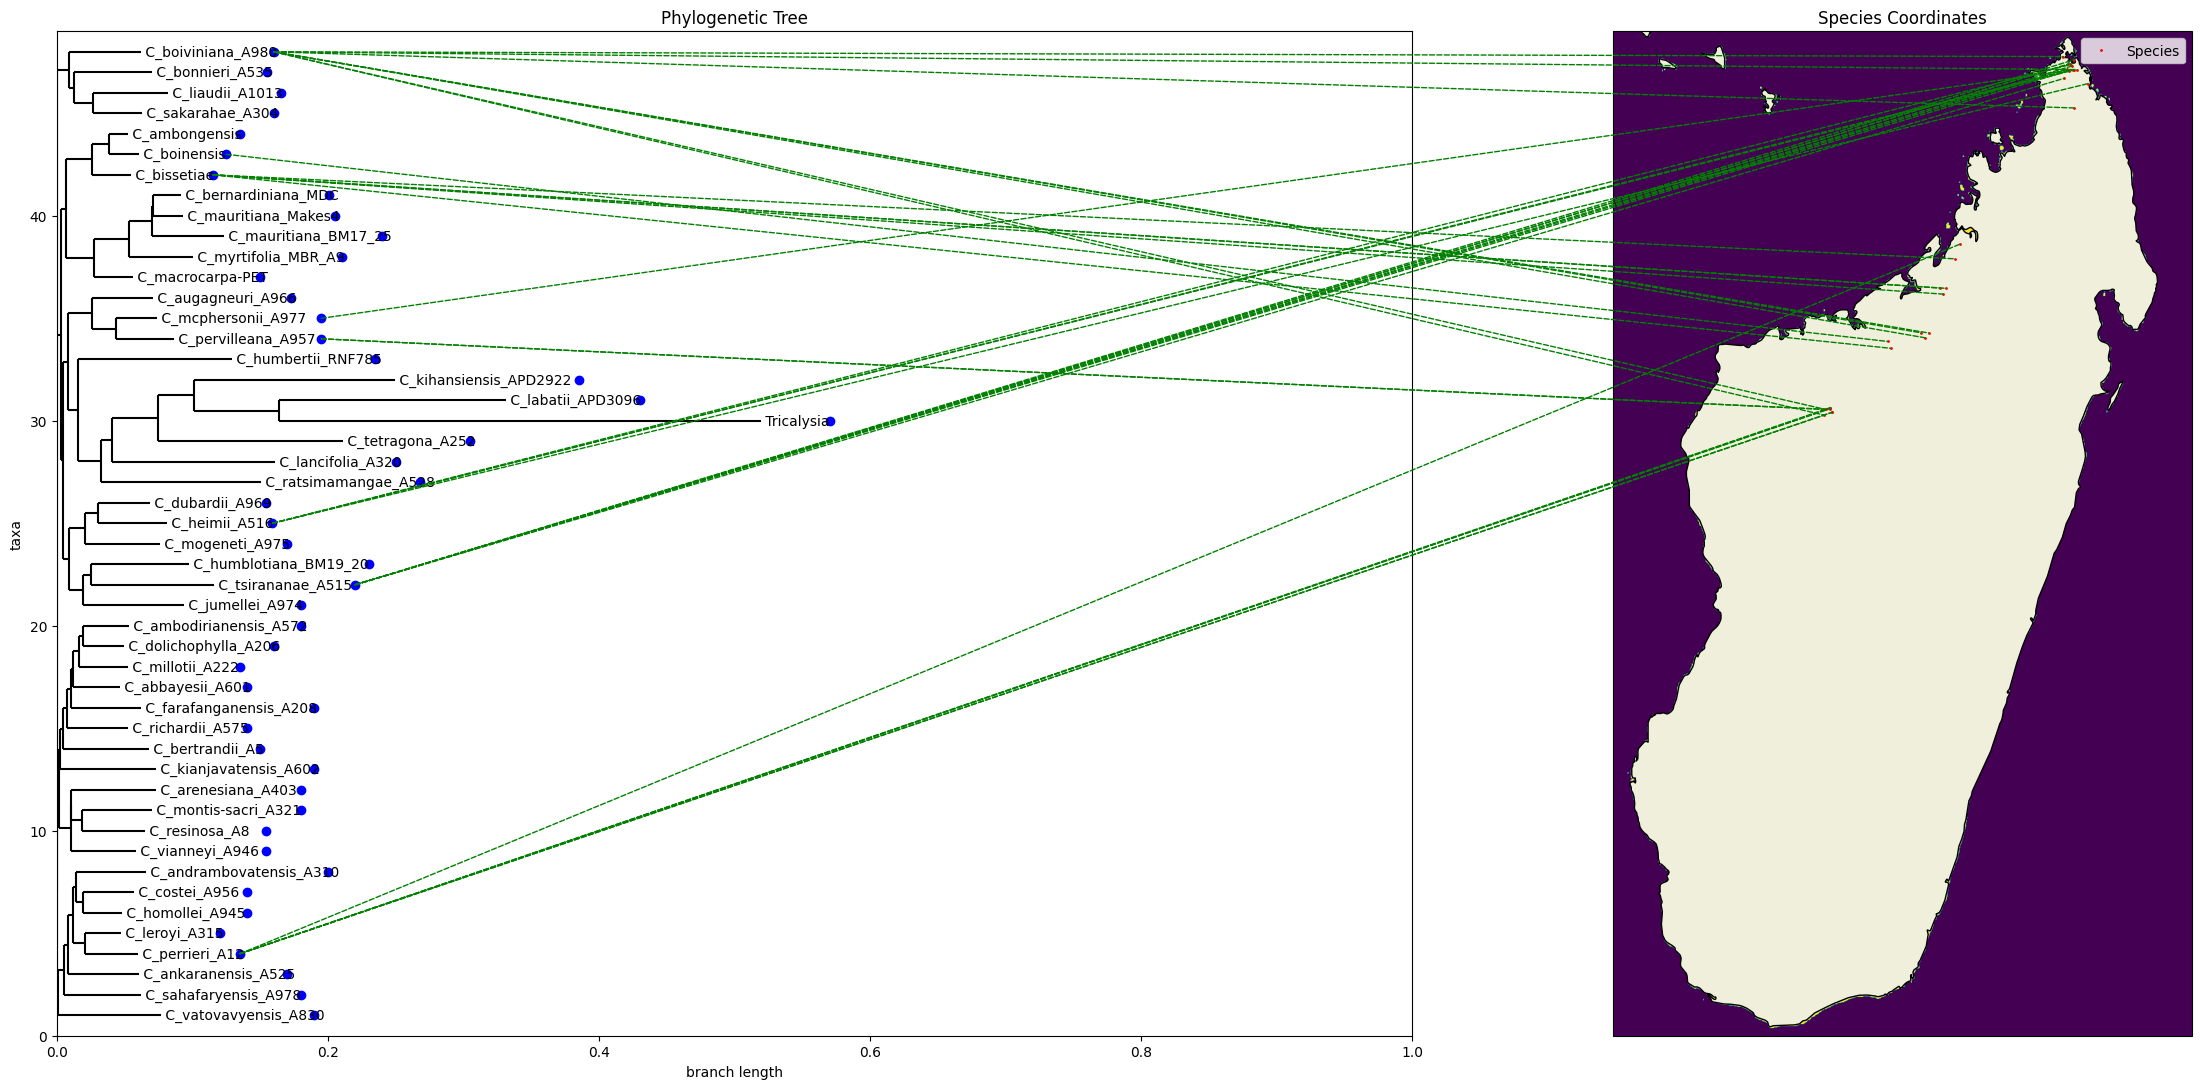

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from rasterio.warp import calculate_default_transform
import tempfile

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"
tiff_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_current.tif"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

# Open the TIFF file and reproject if necessary
with rasterio.open(tiff_file) as src:
    # Calculate default transform and dimensions for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, ccrs.PlateCarree().proj4_init, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': ccrs.PlateCarree().proj4_init,
        'transform': transform,
        'width': width,
        'height': height
    })

    with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmpfile:
        temp_tiff_path = tmpfile.name

    with rasterio.open(temp_tiff_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ccrs.PlateCarree().proj4_init,
                resampling=Resampling.nearest
            )

    with rasterio.open(temp_tiff_path) as reprojected:
        # Set the extent based on the raster data
        extent = [transform[2], transform[2] + transform[0] * width,
                  transform[5] + transform[4] * height, transform[5]]
        ax2.imshow(reprojected.read(1), extent=extent, transform=ccrs.PlateCarree(), origin='upper', cmap='viridis')

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    ax2.plot(row["longitude"], row["latitude"], 'ro', markersize=1)

# Add cartographic features
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.LAND, zorder=0)  # Ensures features are below the raster

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(['Species'], loc='upper right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Group gps DataFrame by ID and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color="green", linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


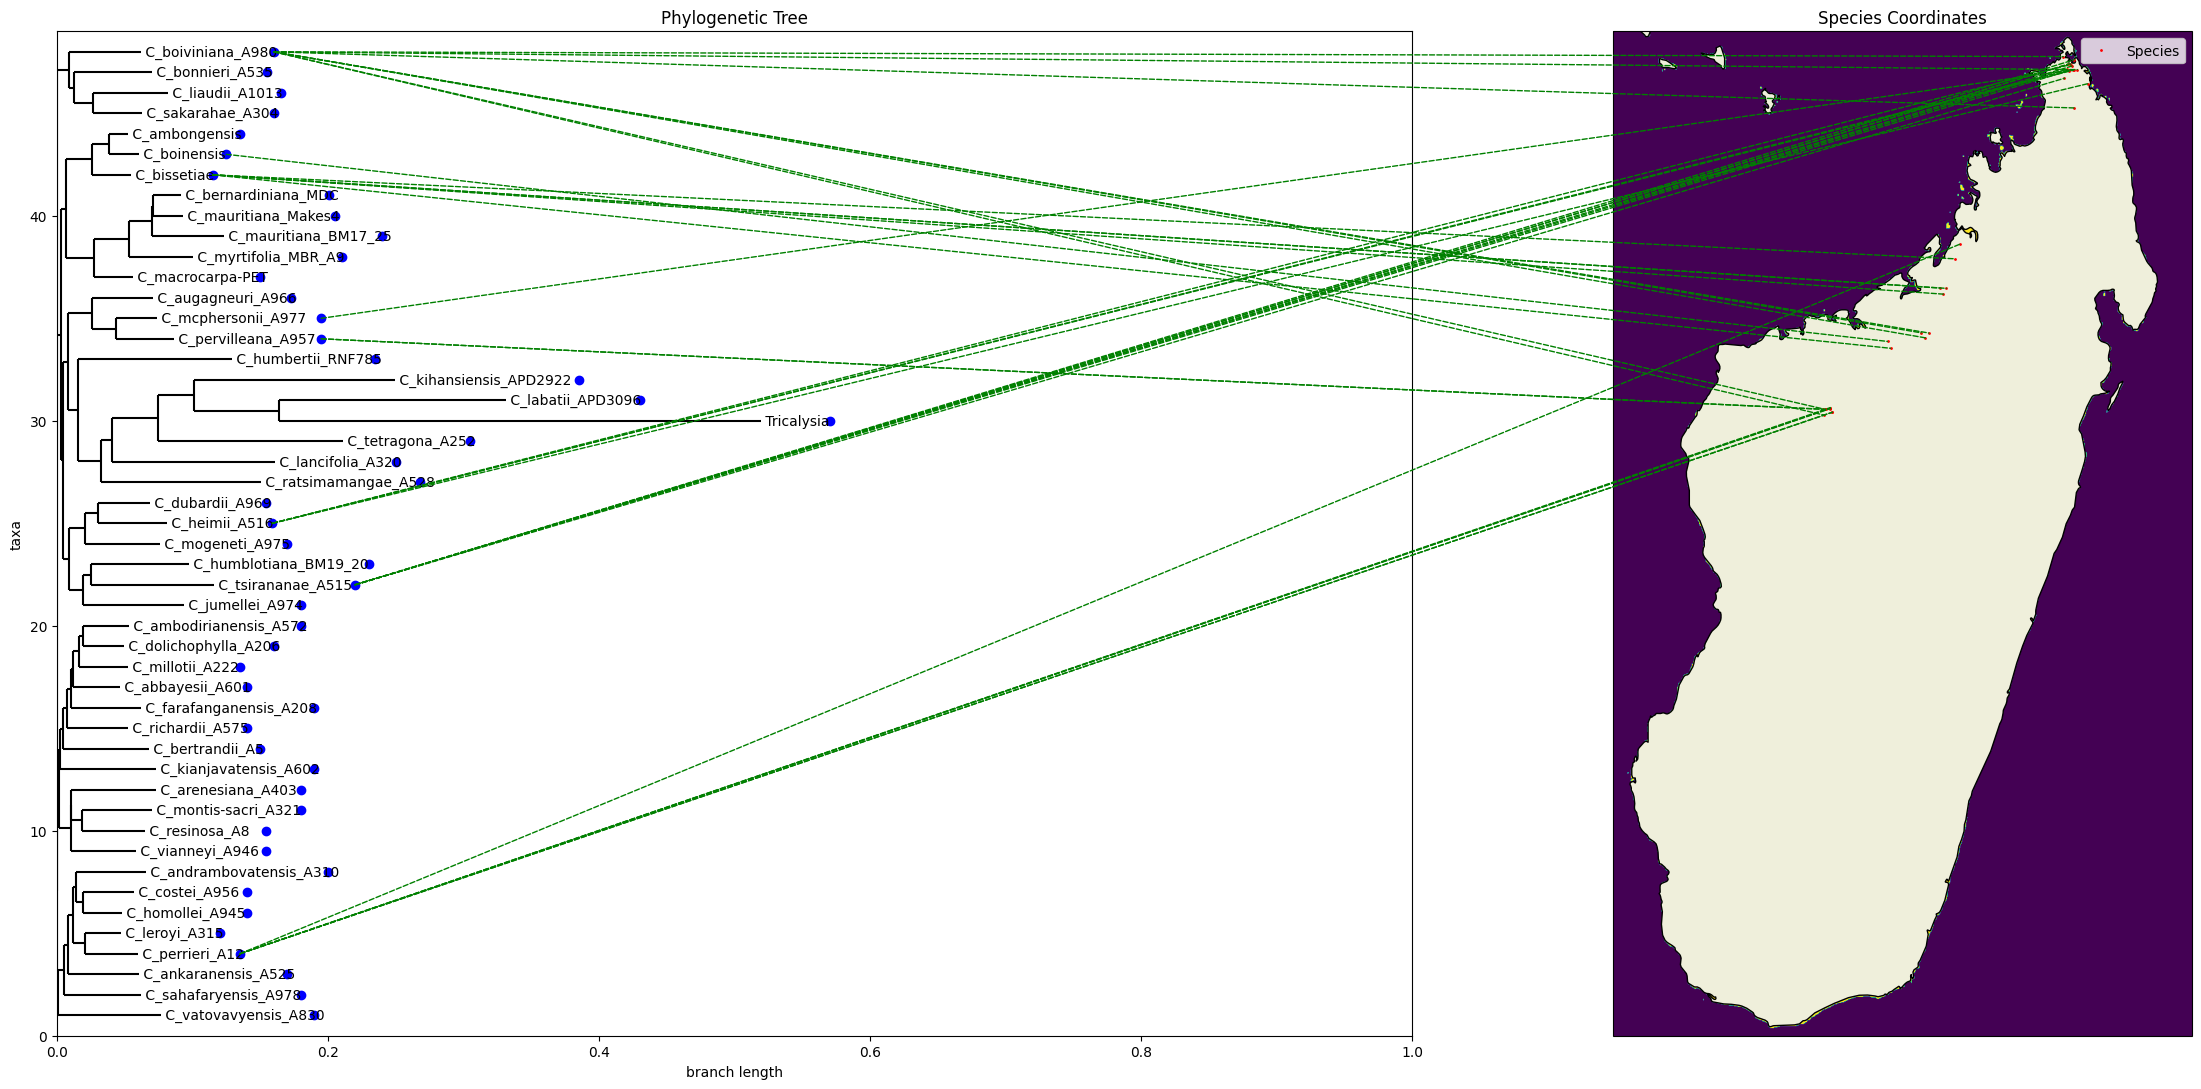

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from Bio import Phylo
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from rasterio.warp import calculate_default_transform
from matplotlib.colors import Normalize
import tempfile
import numpy as np

nwk_file = "../tree/new_phylo_tree.nwk"
offsets_file = "../data/offsets.csv"
tiff_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_current.tif"

# Create a new map with PlateCarree projection
fig = plt.figure(figsize=(26, 11))

# --------------------------------------
# ------------  Phylogenetic MAP -------
# --------------------------------------

def custom_label(clade):
    if clade.is_terminal():
        return clade.name
    else:
        return None

def calc_node_positions(tree, x_start, x_end, y_start, y_step):
    if tree.is_terminal():
        x_pos = x_start
        y_pos = y_start
        y_start += y_step
    else:
        x_pos = (x_start + x_end) / 2
        y_pos = y_start

        child_y_start = y_start
        for child in tree.clades:
            child_x_pos, child_y_pos, y_start = calc_node_positions(child, x_start, x_end, y_start, y_step)
            x_start = child_x_pos

        y_pos = (y_start + child_y_start) / 2

    tree.position = (x_pos, y_pos)
    return x_pos, y_pos, y_start

def get_x_offset(node_name, offsets_dict):
    return offsets_dict.get(node_name, 0)  # default offset is 0 if not found

def plot_adjusted_node(ax, node, y_offset, offsets_dict):
    x, y = node.position
    x_offset = get_x_offset(node.name, offsets_dict)
    x += x_offset
    y += y_offset
    ax.plot(x, y, 'bo')
    return x, y

# Load the tree
tree = Phylo.read(nwk_file, "newick")

# Load offsets from CSV
offsets_df = pd.read_csv(offsets_file)
offsets_dict = pd.Series(offsets_df.XOffset.values, index=offsets_df.NodeName).to_dict()

# Calculate positions for all nodes
y_step = 1
calc_node_positions(tree.root, 0, 1, 0, y_step)

# Create a figure for the subplot
ax_tree = fig.add_subplot(121)

# Plot the tree
Phylo.draw(tree, do_show=False, axes=ax_tree, label_func=custom_label)
ax_tree.set_title("Phylogenetic Tree")

# Set axes limits to verify the data range
ax_tree.set_xlim(0, 1)
ax_tree.set_ylim(0, max(node.position[1] for node in tree.get_terminals()) + 2)

node_positions = {clade.name: clade.position for clade in tree.find_clades()}

# Generate DataFrame with node coordinates
rows = []
for clade in tree.find_clades():
    if clade.is_terminal():
        label = clade.name
        x, y = plot_adjusted_node(ax_tree, clade, y_step, offsets_dict)  # Adjust offsets if necessary
        rows.append([label, (x, y)])

# Create DataFrame with node coordinates
df = pd.DataFrame(rows, columns=["ID", "Coordinates"])

# --------------------------------------
# ------------  GRAPH MAP --------------
# --------------------------------------

gps = pd.read_csv('../data/sample_data_mada.csv')

# Create subplot 2 with the map plot
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

# Open the TIFF file and reproject if necessary
with rasterio.open(tiff_file) as src:
    # Calculate default transform and dimensions for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, ccrs.PlateCarree().proj4_init, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': ccrs.PlateCarree().proj4_init,
        'transform': transform,
        'width': width,
        'height': height
    })

    with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmpfile:
        temp_tiff_path = tmpfile.name

    with rasterio.open(temp_tiff_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ccrs.PlateCarree().proj4_init,
                resampling=Resampling.nearest
            )

    with rasterio.open(temp_tiff_path) as reprojected:
        # Extract the first layer
        data = reprojected.read(1)
        
        # Normalize data for better visibility
        norm = Normalize(vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
        
        # Set the extent based on the raster data
        extent = [transform[2], transform[2] + transform[0] * width,
                  transform[5] + transform[4] * height, transform[5]]
        ax2.imshow(data, extent=extent, transform=ccrs.PlateCarree(), origin='upper', cmap='viridis', norm=norm)

# Plot points from GPS dataframe on the map
for index, row in gps.iterrows():
    ax2.plot(row["longitude"], row["latitude"], 'ro', markersize=1)

# Add cartographic features
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.LAND, zorder=0)  # Ensures features are below the raster

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Species Coordinates")
ax2.legend(['Species'], loc='upper right')

# --------------------------------------
# ------------  Line mapping -----------
# --------------------------------------

# Group gps DataFrame by ID and create a dictionary of lists of coordinates
gps_grouped = gps.groupby('specimen_id')[['longitude', 'latitude']].apply(lambda x: list(zip(x['longitude'], x['latitude']))).to_dict()

# Iterate through each row in df to create connection patches
for index, row in df.iterrows():
    # Get corresponding list of coordinates from gps DataFrame
    if row['ID'] in gps_grouped:
        species_coords_list = gps_grouped[row['ID']]
        # Create connection patches for each coordinate in the list
        for species_coords in species_coords_list:
            con = ConnectionPatch(
                xyA=row['Coordinates'], coordsA="data",
                xyB=species_coords, coordsB="data",
                axesA=ax_tree, axesB=ax2,
                color="green", linewidth=1, linestyle="--",
                zorder=2
            )
            fig.add_artist(con)

# Adjust layout and display
plt.tight_layout()
plt.show()


Data Statistics:
Min: -32768, Max: 228
Mean: -17492.789168221636, Std: 16424.07646289191
Percentiles: 5th=-32768.0, 95th=206.0


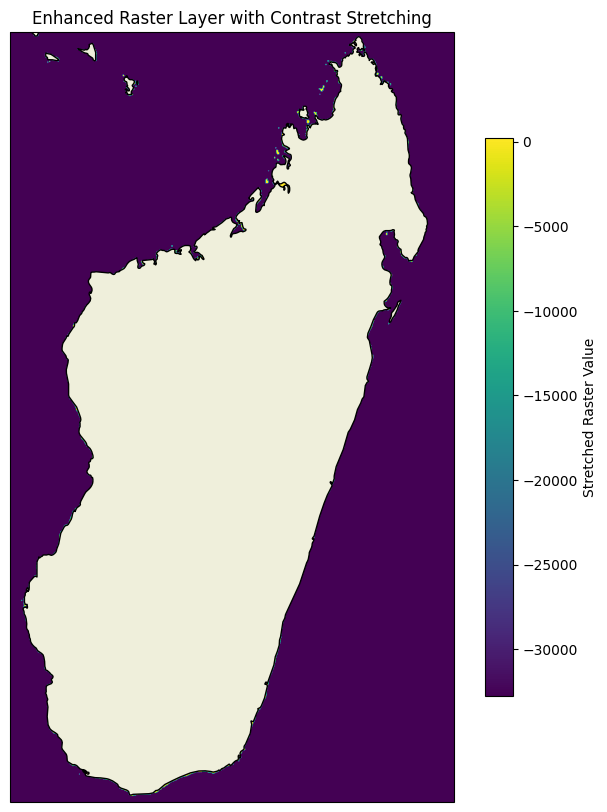

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from matplotlib.colors import Normalize, LogNorm
import tempfile
import numpy as np

tiff_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_current.tif"


# Create a new map with PlateCarree projection
fig, ax2 = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Open the TIFF file and reproject if necessary
with rasterio.open(tiff_file) as src:
    # Calculate default transform and dimensions for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, ccrs.PlateCarree().proj4_init, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': ccrs.PlateCarree().proj4_init,
        'transform': transform,
        'width': width,
        'height': height
    })

    with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmpfile:
        temp_tiff_path = tmpfile.name

    with rasterio.open(temp_tiff_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ccrs.PlateCarree().proj4_init,
                resampling=Resampling.nearest
            )

    with rasterio.open(temp_tiff_path) as reprojected:
        # Extract the first layer
        data = reprojected.read(1)
        
        # Display data statistics
        print("Data Statistics:")
        print(f"Min: {data.min()}, Max: {data.max()}")
        print(f"Mean: {data.mean()}, Std: {data.std()}")
        print(f"Percentiles: 5th={np.percentile(data, 5)}, 95th={np.percentile(data, 95)}")
        
        # Contrast stretching: set low and high percentiles
        p_low, p_high = np.percentile(data, (2, 98))
        data_stretched = np.clip(data, p_low, p_high)
        
        # Normalize the data for visualization
        norm = Normalize(vmin=p_low, vmax=p_high)
        
        # Set the extent based on the raster data
        extent = [transform[2], transform[2] + transform[0] * width,
                  transform[5] + transform[4] * height, transform[5]]
        
        # Plot the raster data with enhanced visibility
        im = ax2.imshow(data_stretched, extent=extent, transform=ccrs.PlateCarree(), origin='upper', cmap='viridis', norm=norm)
        
        # Add a colorbar for the raster data
        cbar = plt.colorbar(im, ax=ax2, orientation='vertical', fraction=0.036, pad=0.04)
        cbar.set_label('Stretched Raster Value')

# Add cartographic features for reference
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.LAND, zorder=0)  # Ensures features are below the raster

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Enhanced Raster Layer with Contrast Stretching")

plt.show()



Data Statistics:
Min: -32768, Max: 228
Mean: -17492.789168221636, Std: 16424.07646289191
Percentiles: 5th=-32768.0, 95th=206.0


C:\Users\forc2101\AppData\Local\Temp\ipykernel_17884\3780909162.py:54: RuntimeWarning: invalid value encountered in log1p
  data_transformed = np.log1p(data - data.min())  # log1p to handle zero and negative values


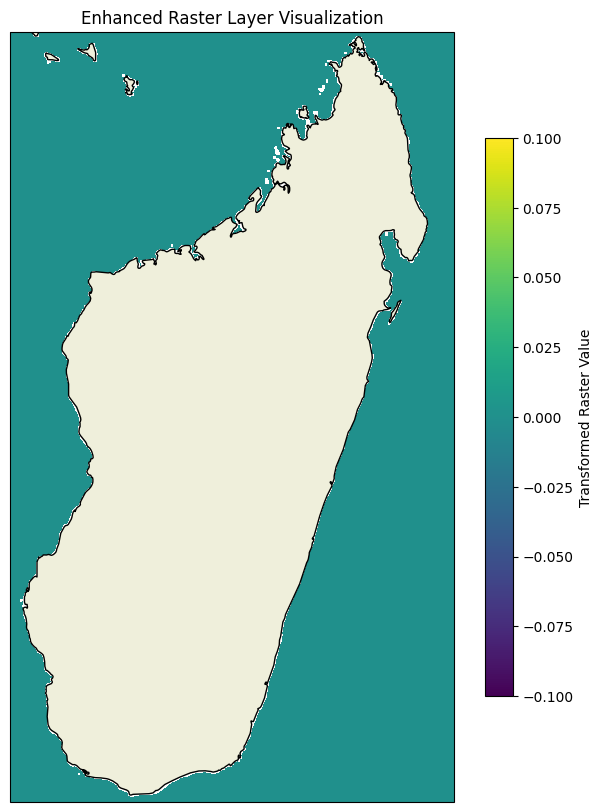

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
import tempfile
import numpy as np
from matplotlib.colors import Normalize, LogNorm

tiff_file = r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_current.tif"

# Create a new map with PlateCarree projection
fig, ax2 = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Open the TIFF file and reproject if necessary
with rasterio.open(tiff_file) as src:
    # Calculate default transform and dimensions for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, ccrs.PlateCarree().proj4_init, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': ccrs.PlateCarree().proj4_init,
        'transform': transform,
        'width': width,
        'height': height
    })

    with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmpfile:
        temp_tiff_path = tmpfile.name

    with rasterio.open(temp_tiff_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ccrs.PlateCarree().proj4_init,
                resampling=Resampling.nearest
            )

    with rasterio.open(temp_tiff_path) as reprojected:
        # Extract the first layer
        data = reprojected.read(1)
        
        # Examine the data statistics
        print("Data Statistics:")
        print(f"Min: {data.min()}, Max: {data.max()}")
        print(f"Mean: {data.mean()}, Std: {data.std()}")
        print(f"Percentiles: 5th={np.percentile(data, 5)}, 95th={np.percentile(data, 95)}")
        
        # Apply log transformation if necessary
        data_transformed = np.log1p(data - data.min())  # log1p to handle zero and negative values
        
        # Set the extent based on the raster data
        extent = [transform[2], transform[2] + transform[0] * width,
                  transform[5] + transform[4] * height, transform[5]]
        
        # Plot the raster data with enhanced visibility
        im = ax2.imshow(data_transformed, extent=extent, transform=ccrs.PlateCarree(), origin='upper', cmap='viridis')
        
        # Add a colorbar for the raster data
        cbar = plt.colorbar(im, ax=ax2, orientation='vertical', fraction=0.036, pad=0.04)
        cbar.set_label('Transformed Raster Value')

# Add cartographic features for reference
ax2.coastlines(resolution='10m')
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.LAND, zorder=0)  # Ensures features are below the raster

ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("Enhanced Raster Layer Visualization")

plt.show()


In [35]:
import rasterio
import rasterio.features
import rasterio.warp

with rasterio.open(r"C:\Users\forc2101\OneDrive - USherbrooke\IFT809\IFT809\py_madaclim\madaclim_current.tif") as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[43.411507, -11.909126], [43.411455, -11.918166], [43.420635, -11.918218], [43.420582, -11.927258], [43.429762, -11.927309], [43.42971, -11.936349], [43.448072, -11.936451], [43.44802, -11.945491], [43.466382, -11.945592], [43.466433, -11.936552], [43.484795, -11.936651], [43.484845, -11.927611], [43.494025, -11.92766], [43.494125, -11.90958], [43.411507, -11.909126]]]}
{'type': 'Polygon', 'coordinates': [[[49.194772, -12.008692], [49.194912, -12.017711], [49.204074, -12.017573], [49.203934, -12.008554], [49.194772, -12.008692]]]}
{'type': 'Polygon', 'coordinates': [[[49.177006, -12.045043], [49.177146, -12.054062], [49.158819, -12.054337], [49.158958, -12.063356], [49.168122, -12.063219], [49.168401, -12.081258], [49.177566, -12.08112], [49.177706, -12.090139], [49.205199, -12.089724], [49.204917, -12.071686], [49.195754, -12.071825], [49.195332, -12.044768], [49.177006, -12.045043]]]}
{'type': 'Polygon', 'coordinates': [[[49.361563, -12.123387], [